# Convolutional Neural Networks


### To do before the lab, using our data set:
- Train CNN on the training set.
- Measure accuracy and 10-fold accuracy.
    - Use metrics: TP and FP rate, precision and recall, F measure, ROC area.
- Experiment with various CNN architectures.

### To do during the lab:
- Make conclusions about experiments, tuning.

### Prepare data

In [61]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np

We loaded our data from the zip file. 
(We cannot use the dataset we used to use for other ml models becuase for CNN the data should not be preprocessed)

#### Load Data

In [9]:
# Unzip file (downloaded file located in the same folder as the notebook) 
zip_file_name = 'waste-classification-data'
with ZipFile(zip_file_name+'.zip', 'r') as files:
    files.extractall(zip_file_name)

In [16]:
# Filter out corrupted images 
num_skipped = 0
for folder_name in ("O", "R"):
    folder_path = os.path.join("waste-classification-data\DATASET\TRAIN", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 359 images


In [17]:
# Generate a dataset from the image
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "waste-classification-data\DATASET\TRAIN",
    validation_split=0.67,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 22205 files belonging to 2 classes.
Using 7328 files for training.
Using 14877 files for validation.


In [29]:
# infor of dataset
train_ds.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

#### Visualize the data

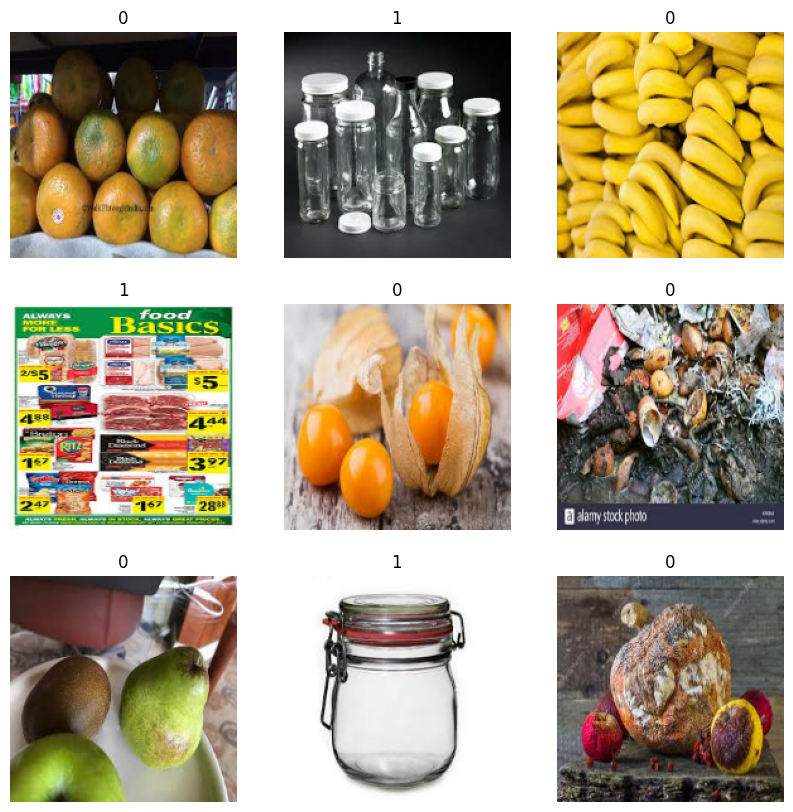

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Build and Fit CNN

In [46]:
def make_model(input_shape, num_classes):
    # Entry block
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Activation("relu")(x)

    # First convolutional & pulling layer set
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    # Second convolutional & pulling layer set    
    x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    # Fully-connected NNN
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

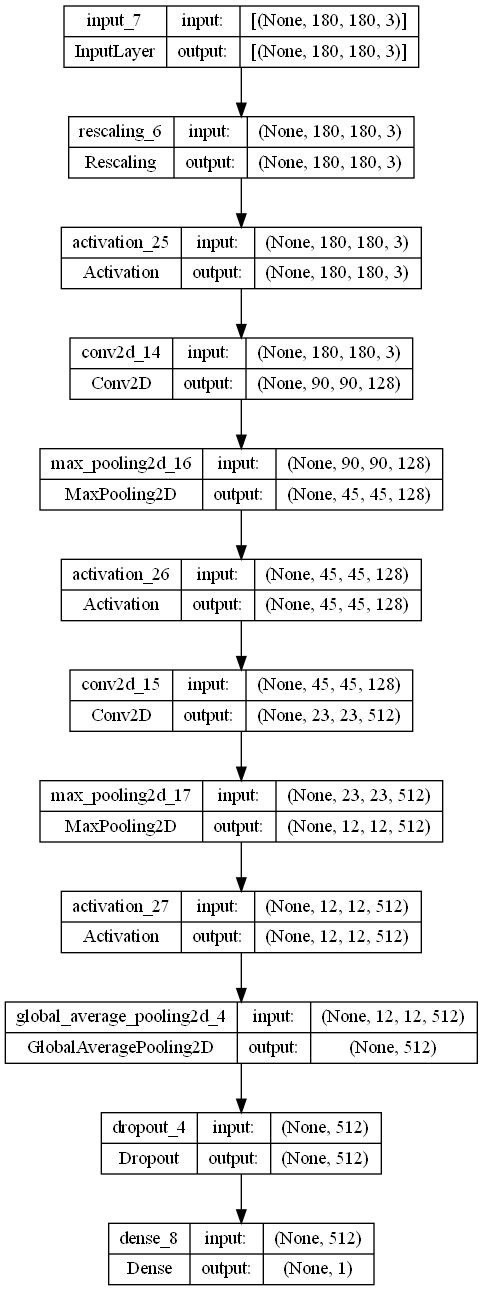

In [47]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [48]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
58/58 [==============================] - 351s 6s/step - loss: 0.5086 - accuracy: 0.7515 - val_loss: 0.4490 - val_accuracy: 0.8053
Epoch 2/25
58/58 [==============================] - 360s 6s/step - loss: 0.4503 - accuracy: 0.8020 - val_loss: 0.4386 - val_accuracy: 0.8080
Epoch 3/25
58/58 [==============================] - 362s 6s/step - loss: 0.4498 - accuracy: 0.8027 - val_loss: 0.4327 - val_accuracy: 0.8062
Epoch 4/25
58/58 [==============================] - 371s 6s/step - loss: 0.4461 - accuracy: 0.8054 - val_loss: 0.4490 - val_accuracy: 0.7857
Epoch 5/25
58/58 [==============================] - 364s 6s/step - loss: 0.4312 - accuracy: 0.8133 - val_loss: 0.4163 - val_accuracy: 0.8211
Epoch 6/25
58/58 [==============================] - 365s 6s/step - loss: 0.4371 - accuracy: 0.8070 - val_loss: 0.4270 - val_accuracy: 0.8038
Epoch 7/25
58/58 [==============================] - 364s 6s/step - loss: 0.4225 - accuracy: 0.8170 - val_loss: 0.4158 - val_accuracy: 0.8211
Epoch 8/25
58

#### Run inference on new data

In [51]:
img = keras.preprocessing.image.load_img(
    "waste-classification-data\DATASET\TRAIN\O\O_1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% organic and {100 * score:.2f}% recyclable.")

1/1 [==============================] - 0s 200ms/step
This image is 74.86% organic and 25.14% recyclable.


### Evaluate the Model

In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score

# make data from for evaluation 
columns = ['Accuracy', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'Area Under RoC Curve']
evaluation_metrics = pd.DataFrame(columns = columns)
evaluation_metrics

,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve


In [85]:
# predict 
pred = model.predict(val_ds).reshape(-1) >= 0.5
# get label 
label = np.array([])
for x, y in val_ds:
    label = np.append(label, y)
    
# evaluate
accuracy = sum(pred == label) / len(pred)
cm = confusion_matrix(label, pred)
tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
precision = precision_score(label, pred)
recall = recall_score(label, pred)
auc = roc_auc_score(pred, label)

index = str(model)
evaluation_metrics.loc[index] = [accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]

evaluation_metrics

117/117 [==============================] - 118s 1s/step


,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve
<keras.engine.functional.Functional object at 0x000001C17B5AFC40>,0.833905,5829.0,1771.0,6577.0,700.0,0.892786,0.787853,0.766974,0.892786,0.83539


### Use face dataset

In [118]:
# load dataset
X = np.load(r'C:\Users\JHL\F21DL\smiley_X.npy')
y = np.load(r'C:\Users\JHL\F21DL\smiley_y.npy')

In [119]:
# shape of X
print("The original shape of X: ", X.shape)

The original shape of X:  (144, 9, 9, 1)


In [120]:
# examine the number of samples in each class
for label in np.unique(y):
    print(f"The number of samples in calss {label}: {sum(y==label)}")

The number of samples in calss 0.0: 72
The number of samples in calss 1.0: 72


In [153]:
# train/test set split
# test set size: 44, train set size: 100 (for 10-fold cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=44, random_state=42)
print(X_train.shape)
print(X_test.shape)

(100, 9, 9, 1)
(44, 9, 9, 1)


In [163]:
y_train.reshape((-1))
y_test.reshape((-1))


array([1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0.])

In [172]:
model = keras.Sequential([
    layers.Conv2D(32, 1, activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [173]:
# Compile and train
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 9, 9, 32)          64        
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 513       
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 1s 51ms/step - loss: 0.7096 - accuracy: 0.3700 - val_loss: 0.6973 - val

In [174]:
# predict 
pred = model.predict(X_test).reshape(-1) >= 0.5

# evaluate
accuracy = sum(pred == y_test) / len(pred)
cm = confusion_matrix(y_test, pred)
tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
#auc = roc_auc_score(pred, y_test)

index = str(model)
evaluation_metrics.loc[index] = [accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]

evaluation_metrics

2/2 [==============================] - 0s 2ms/step


,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve
<keras.engine.functional.Functional object at 0x000001C17B5AFC40>,0.833905,5829.0,1771.0,6577.0,700.0,0.892786,0.787853,0.766974,0.892786,0.83539
<keras.engine.sequential.Sequential object at 0x000001C16BC15090>,0.454545,20.0,24.0,0.0,0.0,1.000000,0.000000,0.454545,1.000000,0.83539
<keras.engine.sequential.Sequential object at 0x000001C16C1C4C10>,0.909091,19.0,3.0,21.0,1.0,0.950000,0.875000,0.863636,0.950000,0.83539


## Try 10-fold Cross Validation Using Face Dataset

In [178]:
# implement 10-fold cross-validation manually and evaluate it using major matics 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score

# make data from for evaluation 
columns = ['Accuracy', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'Area Under RoC Curve']
tenFold_evaluation = pd.DataFrame(columns = columns)
tenFold_evaluation

# split data into 10 groups
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)

for k, (train, test) in enumerate(kfold):
    # create model
    model = keras.Sequential([
        layers.Conv2D(32, 1, activation='relu', input_shape=X_train[0].shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    # compile
    model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

    # fit and predict
    history = model.fit(X_train[train], y_train[train], epochs=30)
    pred = model.predict(X_train[test]).reshape(-1) >= 0.5
    
    # evaluate
    accuracy = sum(pred==y_train[test]) / len(pred)
    cm = confusion_matrix(y_train[test], pred)
    tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    precision = precision_score(y_train[test], pred)
    recall = recall_score(y_train[test], pred)
    auc = roc_auc_score(pred, y_train[test])
    
    index = str(k+1) + "fold"
    tenFold_evaluation.loc[index] = [accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]

tenFold_evaluation

Epoch 1/30
3/3 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.2444
Epoch 2/30
3/3 [==============================] - 0s 4ms/step - loss: 0.7222 - accuracy: 0.2889
Epoch 3/30
3/3 [==============================] - 0s 4ms/step - loss: 0.7150 - accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.3889
Epoch 5/30
3/3 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.4556
Epoch 6/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5667
Epoch 8/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.6222
Epoch 9/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.6333
Epoch 10/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.6444
Epoch 11/30
3/3 [======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.5444
Epoch 18/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.5444
Epoch 19/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.5444
Epoch 20/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.5444
Epoch 21/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.5556
Epoch 22/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.5889
Epoch 23/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.5889
Epoch 24/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.5889
Epoch 25/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6000
Epoch 26/30
3/3 [==============================] - 0s 2ms/step - loss: 0.6320 - accuracy: 0.6444
Epoch 27/30
3/3 [=========================

3/3 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.5222
Epoch 3/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5222
Epoch 4/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.5222
Epoch 5/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.5222
Epoch 6/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.5222
Epoch 7/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.5222
Epoch 8/30
3/3 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6000
Epoch 9/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6222
Epoch 10/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.7000
Epoch 11/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.7444
Epoch 12/30
3/3 [==============================] 

3/3 [==============================] - 0s 4ms/step - loss: 0.5353 - accuracy: 0.9000
Epoch 26/30
3/3 [==============================] - 0s 3ms/step - loss: 0.5304 - accuracy: 0.9000
Epoch 27/30
3/3 [==============================] - 0s 3ms/step - loss: 0.5257 - accuracy: 0.9000
Epoch 28/30
3/3 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.9000
Epoch 29/30
3/3 [==============================] - 0s 3ms/step - loss: 0.5167 - accuracy: 0.9000
Epoch 30/30
1/1 [==============================] - 0s 52ms/step
Epoch 1/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5778
Epoch 2/30
3/3 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.5889
Epoch 3/30
3/3 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.7111
Epoch 4/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.8000
Epoch 5/30
3/3 [==============================] - 0s 4ms/step - loss: 0.6690 - 

,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve
1fold,0.9,5.0,1.0,4.0,0.0,1.000000,0.80,0.833333,1.000000,0.916667
2fold,1.0,5.0,0.0,5.0,0.0,1.000000,1.00,1.000000,1.000000,1.000000
3fold,0.9,5.0,1.0,4.0,0.0,1.000000,0.80,0.833333,1.000000,0.916667
4fold,1.0,5.0,0.0,5.0,0.0,1.000000,1.00,1.000000,1.000000,1.000000
5fold,0.9,5.0,1.0,4.0,0.0,1.000000,0.80,0.833333,1.000000,0.916667
6fold,0.8,5.0,2.0,3.0,0.0,1.000000,0.60,0.714286,1.000000,0.857143
7fold,0.9,4.0,0.0,5.0,1.0,0.800000,1.00,1.000000,0.800000,0.916667
8fold,1.0,5.0,0.0,5.0,0.0,1.000000,1.00,1.000000,1.000000,1.000000
9fold,0.9,6.0,1.0,3.0,0.0,1.000000,0.75,0.857143,1.000000,0.928571
10fold,0.7,5.0,2.0,2.0,1.0,0.833333,0.50,0.714286,0.833333,0.690476


### Experiment with Variose Parameters

In [182]:
def make_model(input_shape, num_classes):
    # Entry block
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Activation("relu")(x)

    # First convolutional & pulling layer set
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    # Second convolutional & pulling layer set    
    x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    
    # Fully-connected NNN
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

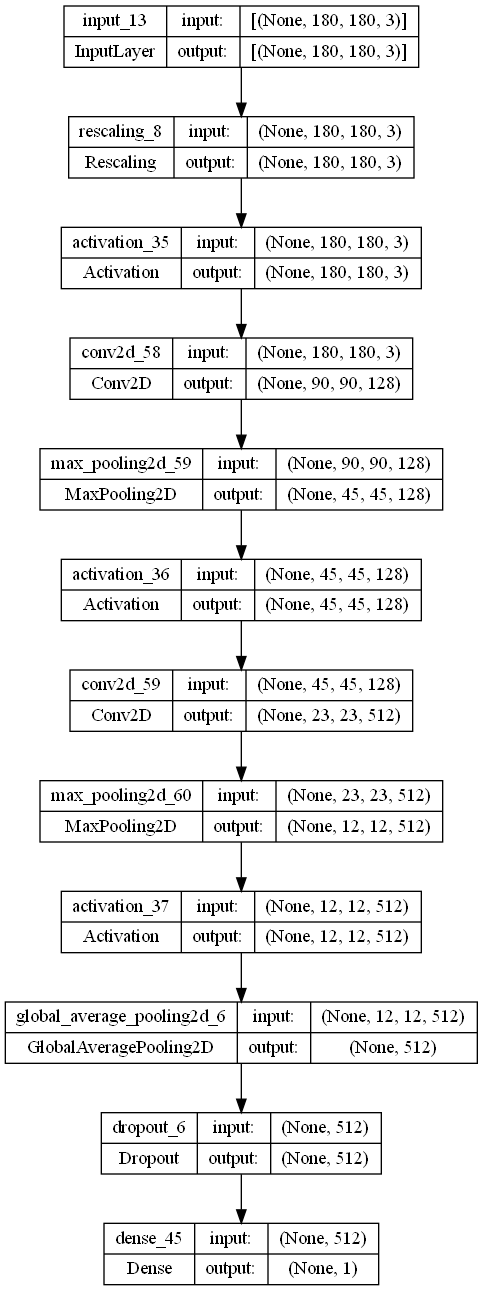

In [183]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

#### Change Optimizer

In [185]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
58/58 [==============================] - 375s 6s/step - loss: 0.6735 - accuracy: 0.5970 - val_loss: 0.6679 - val_accuracy: 0.5628
Epoch 2/25
58/58 [==============================] - 393s 7s/step - loss: 0.6630 - accuracy: 0.6309 - val_loss: 0.6561 - val_accuracy: 0.6015
Epoch 3/25
58/58 [==============================] - 393s 7s/step - loss: 0.6498 - accuracy: 0.6676 - val_loss: 0.6420 - val_accuracy: 0.7313
Epoch 4/25
58/58 [==============================] - 372s 6s/step - loss: 0.6347 - accuracy: 0.7061 - val_loss: 0.6254 - val_accuracy: 0.7403
Epoch 5/25
58/58 [==============================] - 362s 6s/step - loss: 0.6173 - accuracy: 0.7273 - val_loss: 0.6058 - val_accuracy: 0.7409
Epoch 6/25
58/58 [==============================] - 357s 6s/step - loss: 0.5977 - accuracy: 0.7328 - val_loss: 0.5854 - val_accuracy: 0.7434
Epoch 7/25
58/58 [==============================] - 357s 6s/step - loss: 0.5779 - accuracy: 0.7432 - val_loss: 0.5667 - val_accuracy: 0.7488
Epoch 8/25
58

In [186]:
# predict 
pred = model.predict(val_ds).reshape(-1) >= 0.5
# get label 
label = np.array([])
for x, y in val_ds:
    label = np.append(label, y)
    
# evaluate
accuracy = sum(pred == label) / len(pred)
cm = confusion_matrix(label, pred)
tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
precision = precision_score(label, pred)
recall = recall_score(label, pred)
auc = roc_auc_score(pred, label)

index = str(model)
evaluation_metrics.loc[index] = [accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]

evaluation_metrics

117/117 [==============================] - 118s 1s/step


,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve
<keras.engine.functional.Functional object at 0x000001C17B5AFC40>,0.833905,5829.0,1771.0,6577.0,700.0,0.892786,0.787853,0.766974,0.892786,0.835390
<keras.engine.sequential.Sequential object at 0x000001C16BC15090>,0.454545,20.0,24.0,0.0,0.0,1.000000,0.000000,0.454545,1.000000,0.835390
<keras.engine.sequential.Sequential object at 0x000001C16C1C4C10>,0.909091,19.0,3.0,21.0,1.0,0.950000,0.875000,0.863636,0.950000,0.835390
<keras.engine.functional.Functional object at 0x000001C16AD10AC0>,0.775761,4925.0,1732.0,6616.0,1604.0,0.754327,0.792525,0.739823,0.754327,0.772344


### Experiment with Convolution

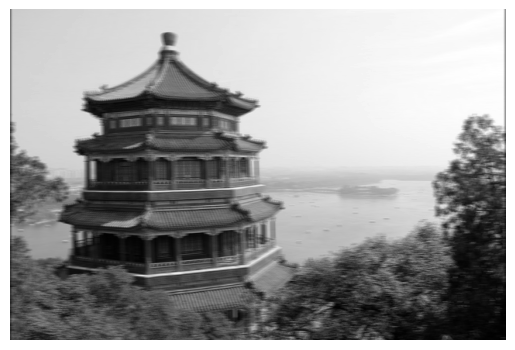

In [200]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

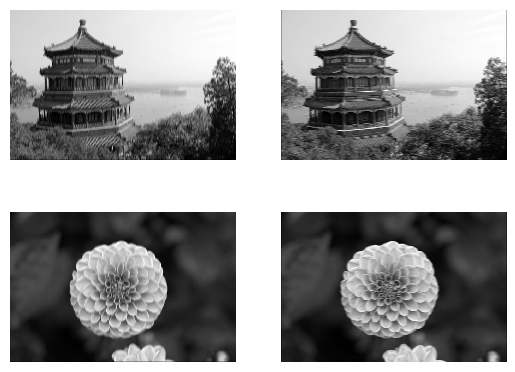

In [197]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

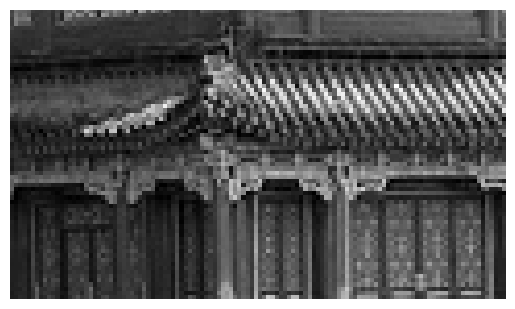

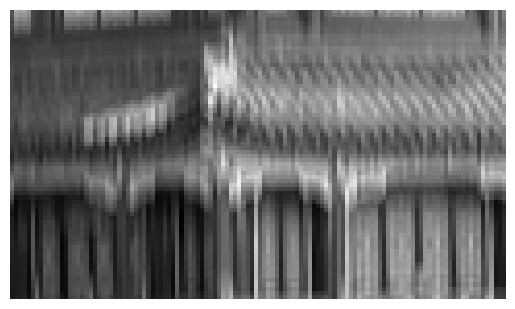

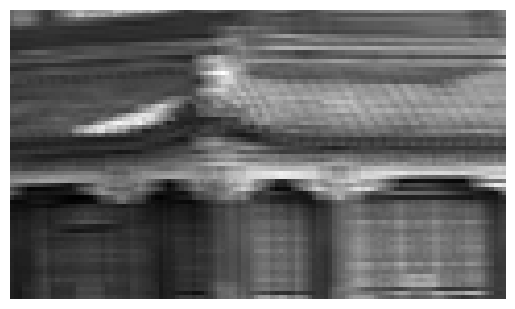

In [203]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()